In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import Convex as cvx 
import MeshCat as mc 
using Test
using Random
import Convex as cvx 
import ForwardDiff as FD
import ECOS      
include(joinpath(@__DIR__,"ref_traj.jl"))
include(joinpath(@__DIR__,"planar_hexrotor_dynamics.jl"))

  Activating environment at `c:\Users\scott\Documents\OCRL\MPCwZAC\Project.toml`

animate_hexrotor (generic function with 1 method)

In [2]:
function kalman_filter(A, B, C, D, Q, R, x_hat, P, u, y, W, w)
    # w is the wind input 
    # W is the system response to wind 
    x_hat_minus = A * x_hat + B * u + W * w
    P_minus = A * P * A' + Q
    K = P_minus * C' / (C * P_minus * C' + R)
    x_hat_plus = x_hat_minus + K * (y - C * x_hat_minus - D * u)
    P_plus = (I - K * C) * P_minus
    
    return x_hat_plus, P_plus
end

function update_wind(current_wind, dt, intensity)
    # Random walk update
    d_wind = randn(size(current_wind)) .* sqrt(intensity * dt)
    new_wind = current_wind + d_wind
    return new_wind
end



update_wind (generic function with 1 method)

In [3]:
"""
`u = convex_mpc(A,B,X_ref_window,xic,xg,u_min,u_max,N_mpc)`

setup and solve the above optimization problem, returning the 
first control u_1 from the solution (should be a length nu 
Vector{Float64}).  
"""
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    xic::Vector, # current state x 
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    Q, #Q cost
                    R, #Input cost
                    wind_dynamics::Matrix, # discrete dynamics of wind W
                    wind_velocity::Vector # current wind state w
                    ) # return the first control command of the solved policy 
    
    # get our sizes for state and control
    nx,nu = size(B)
    
    # check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    @assert length(X_ref_window) == N_mpc 
    @assert size(Q) == (nx, nx)
    @assert size(R) == (nu, nu)

    # variables we are solving for
    X = cvx.Variable(nx,N_mpc)
    U = cvx.Variable(nu,N_mpc-1)

    obj = 0 

    for i = 1:N_mpc-1
        obj += (0.5*cvx.quadform(X[:,i]-X_ref_window[i], Q)+0.5*cvx.quadform(U[:,i], R))
    end
    obj += 0.5*cvx.quadform(X[:,N_mpc]-X_ref_window[N_mpc], Q)

    # create problem with objective
    prob = cvx.minimize(obj)

    prob.constraints += (X[:,1] == xic)
    for i = 1:N_mpc-1
        prob.constraints += (X[:,i+1] == A*X[:,i] + B*U[:,i] + wind_dynamics * wind_velocity)
        # prob.constraints += (X[:,i+1] == A*X[:,i] + B*U[:,i])
        prob.constraints += (u_min ≤ U[:,i])
        prob.constraints += (U[:,i] ≤ u_max)
    end
    

    # solve problem 
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # get X and U solutions 
    X = X.value
    U = U.value

    # return first control U 
    Ucontrol = U[:,1]
    return Ucontrol, X
end

convex_mpc

In [39]:
# Drone parameters
Ixx= 2.331e2
Iyy= 2.322e2
Izz= 4.022e2
model = (mass= 6.728,
    J= Diagonal([Ixx, Iyy, Izz]), 
    gravity= [0,0,-9.81],
    L= 1.075, 
    kf= 0.1, # constant thrust coefficient 
    km= 0.01, # propeller drag coefficient
    dt= 0.1, # 100 Hz
    α= 0 * (π / 180), # optimal value determined from paper
    β= 0 * (π / 180), # optimal value determined from paper
    λ= (((π/3))) # each propeller is 60 degrees from each other TODO fix this (?)
)
# Simulation parameters
dt = model.dt
N = 300
time = 1:N
n_states = 12
n_inputs = 6

# Initialize Kalman Filter parameters
Qkf = I*1
Rkf = I*1

# Initialize wind parameters
wind_dynamics = zeros(n_states, 3)
wind_dynamics[4, 1] = 1  # Wind effect on vx
wind_dynamics[5, 2] = 1  # Wind effect on vy
wind_dynamics[6, 3] = 1  # Wind effect on vz
wind_velocity = [0, 0, 0] # Intensity of the turbulence
wind_intensity = 0.5

# Generate hover trajectory for hexrotor
X_ref, U_ref = create_ref_hover(model, N+N_mpc, dt, n_inputs)
# Generate equilibrium Point
Xbar = X_ref[1]
Ubar = U_ref[1]

# MPC Parameters
Q = diagm([1,1,1,
    0.1,0.1,0.1,
    0.1,0.1,0.1,
    0.1,0.1,0.1])
R = diagm(ones(n_inputs)*0.005)
N_mpc = 20
u_min = zeros(n_inputs) - Ubar
u_max = 10000*ones(n_inputs)+ Ubar

# check dimensions
@assert length(X_ref[1]) == n_states
@assert length(U_ref[1]) == n_inputs

true_states = []
estimated_states = []
inputs = []

# initialize sim variables
P = I(n_states)
true_state = Xbar + randn(n_states) * 0.01
x_hat = true_state
u_mpc = Ubar
measurements = true_state


# Linearize system
#A, B = linearize(X_ref[1], U_ref[1], dt)
A = FD.jacobian(dx -> rk4(model, hexrotor_dynamics, dx, Ubar, dt), Xbar)
B = FD.jacobian(du -> rk4(model, hexrotor_dynamics, Xbar, du, dt), Ubar)
C = I(n_states)
D = zeros(n_states, n_inputs)

X_mpcs = []

# Update simulation loop to include wind update
for i in time
    # Update wind with turbulence model
    #wind_velocity = update_wind(wind_velocity, dt, wind_intensity)

    # Run KF
    x_hat, P = kalman_filter(A, B, C, D, Qkf, Rkf, x_hat, P, u_mpc, measurements, wind_dynamics, wind_velocity)
    
    push!(estimated_states, x_hat)

    #  given a window of N_mpc timesteps, get current reference trajectory
    X_ref_tilde = X_ref[i:i+N_mpc-1]
    
    # call convex mpc controller with state estimate 
    u_mpc, X_mpc = convex_mpc(A, B, X_ref_tilde, true_state, u_min, u_max, N_mpc, Q, R, wind_dynamics, wind_velocity)
    #u_mpc = u_mpc + U_ref[1]
    # u_mpc = [6000, 0, 0, 0, 0, 0]
    # u_mpc = U_ref[1]
    u_mpc = clamp.(u_mpc+Ubar, u_min, u_max)
    push!(inputs, u_mpc)
    push!(X_mpcs, X_mpc)
    
    # simulate next state
    true_state = rk4(model, hexrotor_dynamics, true_state, u_mpc, dt)
    # true_state = A*(true_state - Xbar) + B*(u_mpc - Ubar) + Xbar
    push!(true_states, true_state)

    measurements = true_state + randn(n_states) * 0.001
end



In [ ]:
# print(X_mpcs)
X_mpc = X_mpcs[1]
print(X_mpc)

for i in 1:n_states
    p = plot(1:N_mpc, X_mpc[i, :], label="MPC trajectory")
    display(p)
end

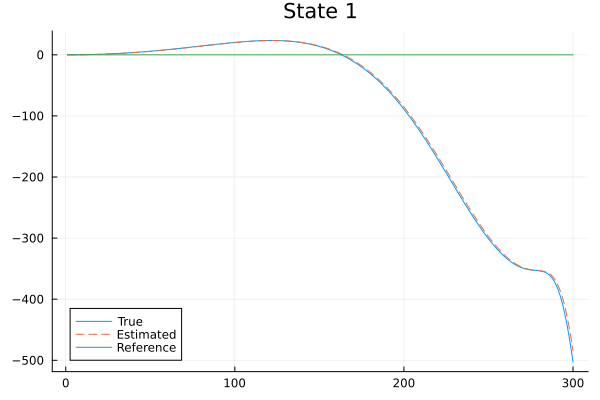

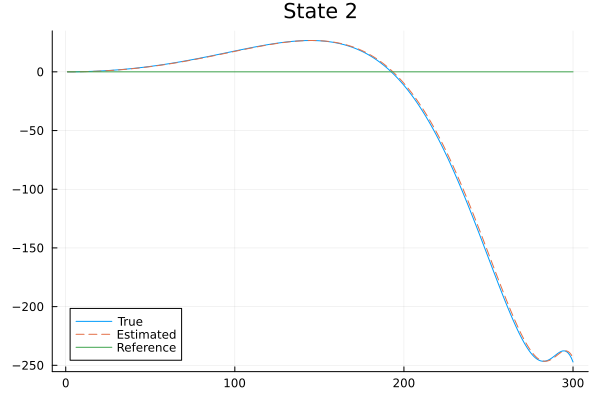

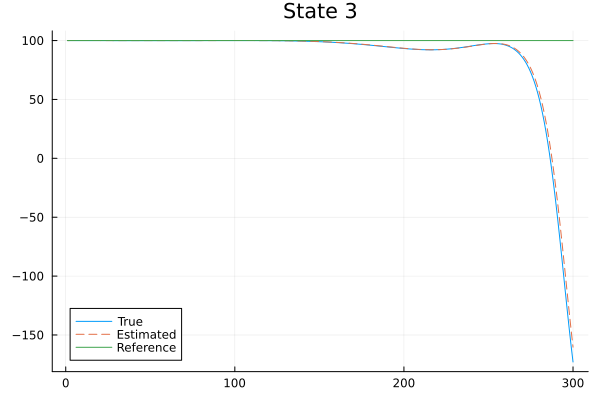

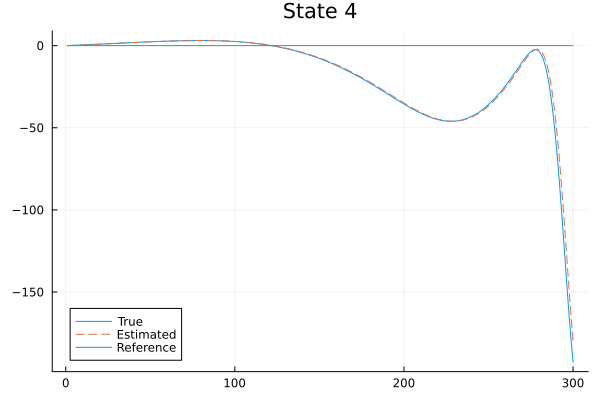

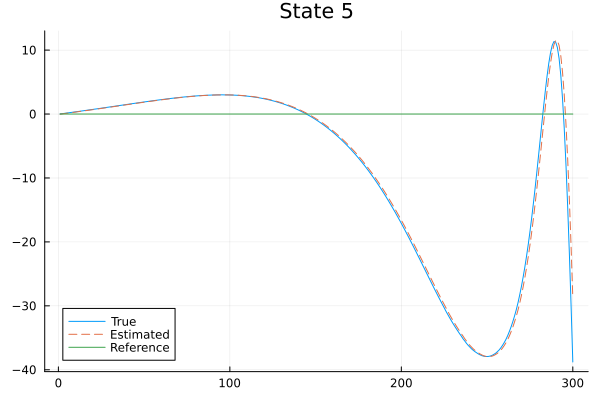

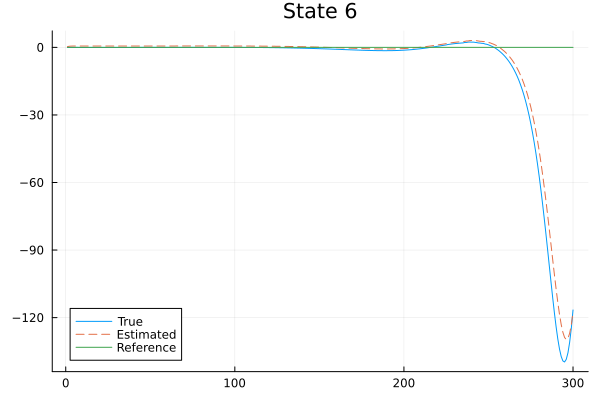

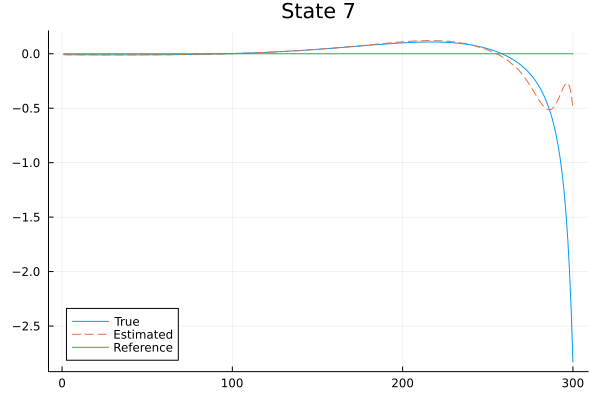

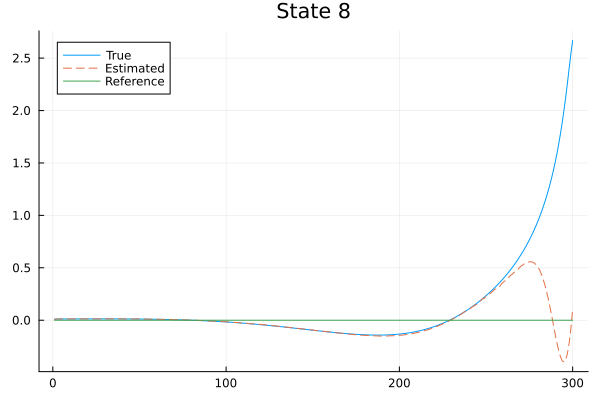

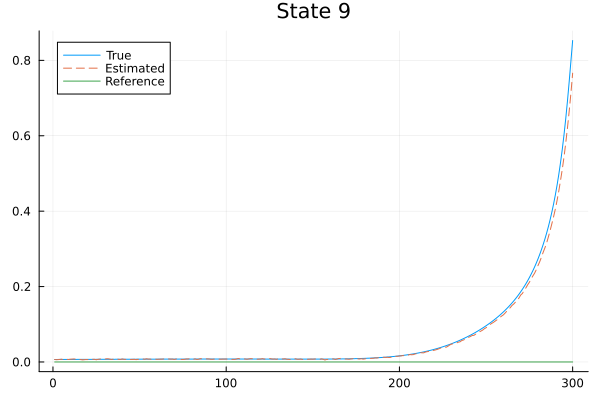

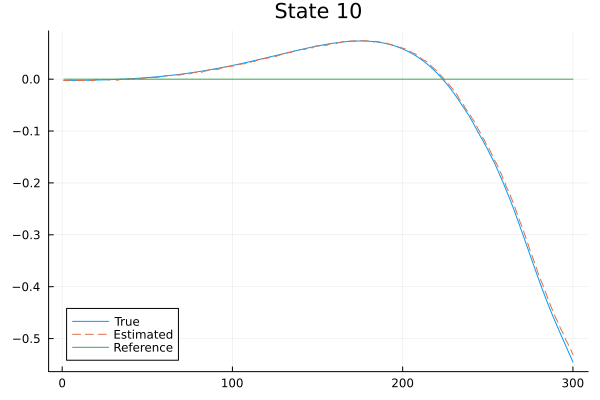

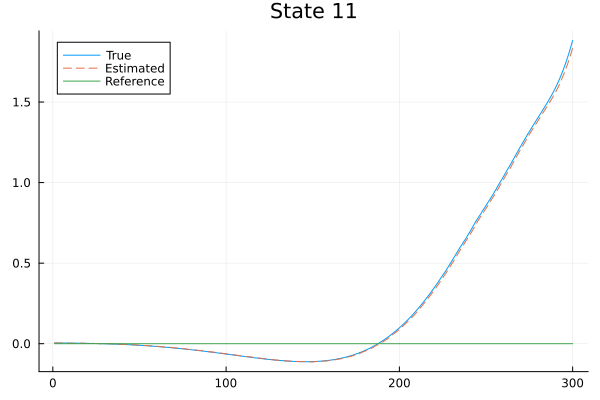

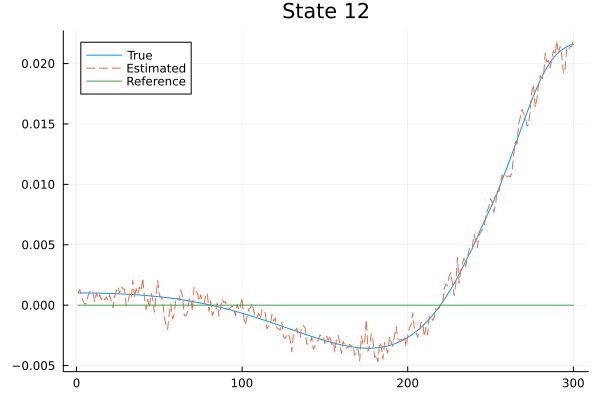

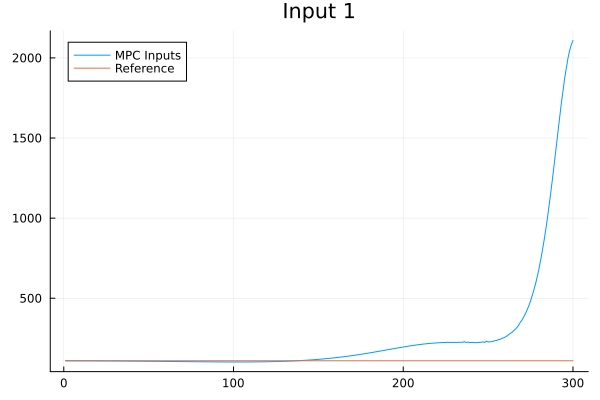

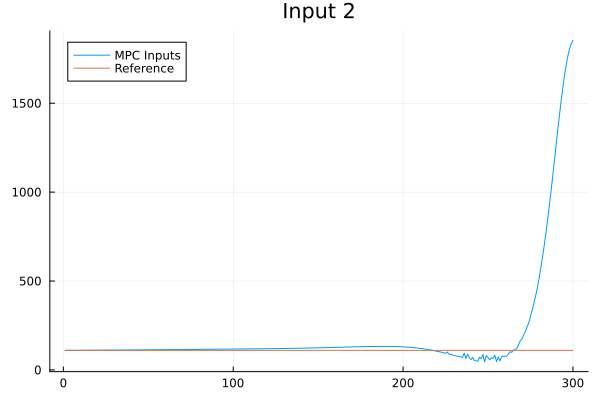

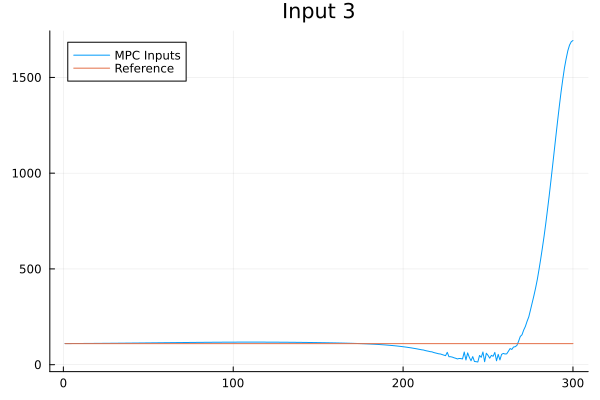

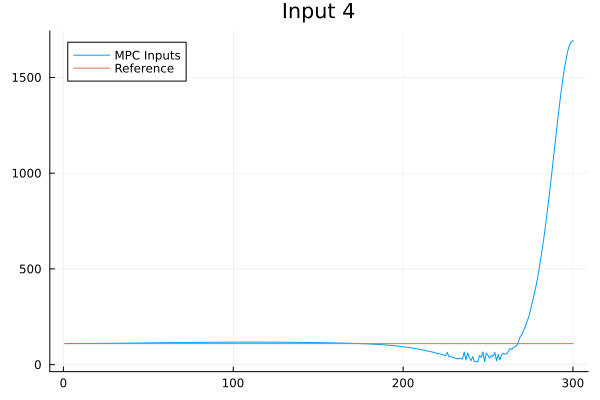

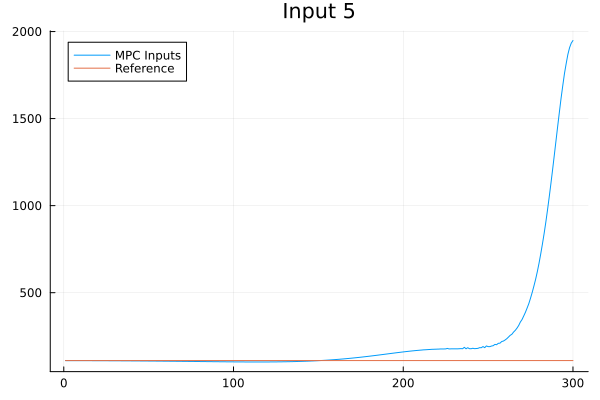

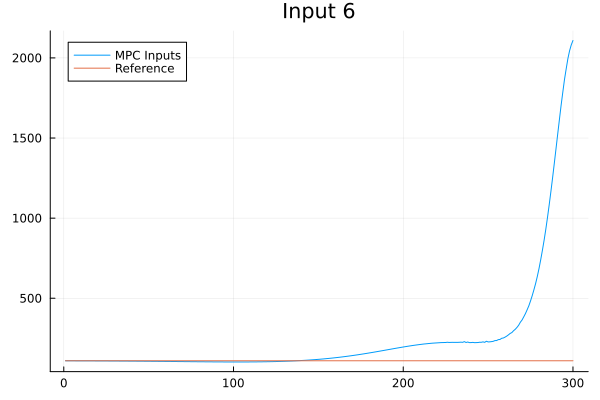

In [40]:

# Convert results to arrays for plotting
true_states_plot = hcat(true_states...)
estimated_states_plot = hcat(estimated_states...)
U_ref_plot = hcat(U_ref...)
X_ref_plot = hcat(X_ref...)
inputs_plot = hcat(inputs...)


# Plotting
for i in 1:n_states
    p = plot(time, true_states_plot[i, :], label="True")
    plot!(time, estimated_states_plot[i, :], label="Estimated", linestyle=:dash)
    plot!(time, X_ref_plot[i, 1:N], label = "Reference")
    title!("State $i")
    display(p)
end
for i in 1:n_inputs
    p = plot(time, inputs_plot[i, :], label="MPC Inputs")
    plot!(time, U_ref_plot[i, 1:N], label = "Reference")
    title!("Input $i")
    display(p)
end

In [7]:
Xsim = hcat()
Xref = hcat()


display(animate_hexrotor(Xsim, Xref, model.dt))

[1.2694594971946182e-5, 0.7493850114236067, 1.5447398218135089, 2.3854031911250333, 3.2706971083758836, 4.199927394631107, 5.172383178755187, 6.187339784712093, 7.244054713162763, 8.341774098496304, 9.479723917661703, 10.657124880855793, 11.873186992045097, 13.127075461898327, 14.417994051878383, 15.745108110519915, 17.107556321402487, 18.504508861576646, 19.935013182716915, 21.398354186922965, 22.893511359060888, 24.41965113674038, 25.97567601729205, 27.56096434202011, 29.17486213621281, 30.815252234016462, 32.482876803530544, 34.17501205474732, 35.89260523676437, 37.63373174789641, 39.39585273837652, 41.18177844480034, 42.98682212788808, 44.81153324417161, 46.65529863056711, 48.51996630159219, 50.3957734039723, 52.28994439681932, 54.19876265861523, 56.12097924814808, 58.05394159088557, 60.00117623456608, 61.95904138186599, 63.927586593780816, 65.9049864050697, 67.88948637239677, 69.88458871327904, 71.87803907526634, 73.88101411496842, 75.88730080950711, 77.8972077211792, 79.907982967

 101.32405758272418, 100.97020560869898, 100.59771666107868, 100.23330421149114, 99.88704362207059, 99.54151330762046, 99.21677902269677, 98.89736560252358, 98.55500361267289, 98.23956091816027, 97.93634323279332, 97.63021698505942, 97.33894848170816, 97.06427397197595, 96.78067640790528, 96.52045478913527, 96.25074345672446, 96.00823314037436, 95.76011511639891, 95.52173869453348, 95.29193490528584, 95.07209690017483, 94.8598991998615, 94.66520282933385, 94.46564639414619, 94.2816719140856, 94.10167557748458, 93.9304625993127, 93.77173627869514, 93.64210033571261, 93.47806655569228, 93.34180004947359, 93.23774356003632, 93.1214824886447, 92.98939286123336, 92.88345829272501, 92.79877288179456, 92.7090650345658, 92.6450745546247, 92.57002243873573, 92.51267841483929, 92.46286072606895, 92.42556264305082, 92.38892803009966, 92.36841080590855, 92.35190266036152, 92.34522296817983, 92.34924281141646, 92.35458946551334, 92.37269641844047, 92.39518242673495, 92.43985884449597, 92.4797263399